## Classification assignment - beat me using only feature engineering!

In this assignment, I have built a gradient boosted machine using Feature-engine for the feature engineering steps.


### Can you beat me by implementing other feature engineering steps?

You can build the engineering steps using Feature-engine, Scikit-learn, pandas or whatever you choose. But the model has to have exactly the same parameters I use in this notebook, and the separation into train and test has to be the same (make sure you set the random_state as I do here).

When you beat me, make a PR to my github repo, and upload your notebook, so others can learn from you as well!!

Have fun!!

In [1]:
# to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline as pipe

from feature_engine import missing_data_imputers as mdi
from feature_engine import discretisers as dsc
from feature_engine import categorical_encoders as ce

pd.pandas.set_option('display.max_columns', None)

In [2]:
# load dataset
cols = ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']
data = pd.read_csv('../titanic.csv', usecols = cols)
data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,female,29.0000,0,0,24160,211.3375,B5,S
1,1,1,male,0.9167,1,2,113781,151.5500,C22,S
2,1,0,female,2.0000,1,2,113781,151.5500,C22,S
3,1,0,male,30.0000,1,2,113781,151.5500,C22,S
4,1,0,female,25.0000,1,2,113781,151.5500,C22,S


In [3]:
# mixed variables

# Cabin
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captures the first letter

# ticket
data['ticket_num'] = data['ticket'].apply(lambda s: s.split()[-1])
data['ticket_num'] = pd.to_numeric(data['ticket_num'],
                                   errors='coerce',
                                   downcast='integer')
data['ticket_cat'] = data['ticket'].apply(lambda s: s.split()[0])
data['ticket_cat'] = np.where(data['ticket_cat'].str.isdigit(), np.nan,
                              data['ticket_cat'])

# show dataframe
data.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked,cabin_num,cabin_cat,ticket_num,ticket_cat
0,1,1,female,29.0000,0,0,24160,211.3375,B5,S,5.0,B,24160.0,NaN
1,1,1,male,0.9167,1,2,113781,151.5500,C22,S,22.0,C,113781.0,NaN
2,1,0,female,2.0000,1,2,113781,151.5500,C22,S,22.0,C,113781.0,NaN
3,1,0,male,30.0000,1,2,113781,151.5500,C22,S,22.0,C,113781.0,NaN
4,1,0,female,25.0000,1,2,113781,151.5500,C22,S,22.0,C,113781.0,NaN


Now that we extracted the numerical and categorical part, we can discard the mixed variables.

I will also discard highly cardinal variables.

In [4]:
# drop original mixed

data.drop(['cabin', 'ticket'], axis=1, inplace=True)

In [5]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1178, 11), (131, 11))

In [6]:
titanic_pipe = pipe([

    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(
         arbitrary_number=-1,
         variables=['age', 'fare', 'ticket_num', 'cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalVariableImputer(
         variables=['embarked', 'cabin_cat', 'ticket_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelCategoricalEncoder(
         tol=0.05,
         n_categories=6,
         variables=['cabin_cat', 'ticket_cat', 'sex', 'embarked'])),
    ('categorical_encoder',
     ce.OrdinalCategoricalEncoder(
         encoding_method='ordered',
         variables=['cabin_cat', 'ticket_cat', 'sex', 'embarked'])),

    # Gradient Boosted machine
    ('gbm',
     GradientBoostingClassifier(criterion='friedman_mse',
                                init=None,
                                learning_rate=0.1,
                                loss='deviance',
                                max_depth=3,
                                max_features=None,
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                n_estimators=20,
                                n_iter_no_change=None,
                                presort='auto',
                                random_state=0,
                                subsample=1.0,
                                tol=0.0001,
                                validation_fraction=0.1,
                                verbose=0,
                                warm_start=False))
])

In [7]:
# let's explore the ticket categorical part a bit further
titanic_pipe.fit(X_train, y_train)

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [8]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.8765221604622248
Test set
GBM roc-auc: 0.8368473895582329


**Can you beat the performance of my GBM using only feature engineering?**

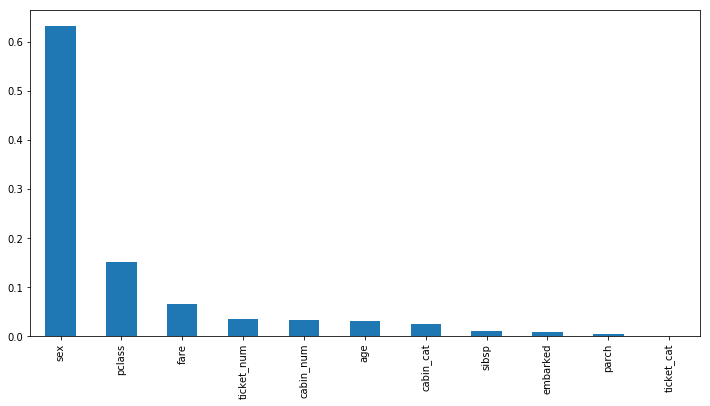

In [9]:
# let's explore the importance of the features

importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))